In [47]:
# Import required libraries
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import numpy as np
import os
import json

# Import DetectionMetrics components
from detectionmetrics.datasets.yolo import YOLODataset
from detectionmetrics.models.torch_detection import TorchImageDetectionModel

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [48]:
# Create directories for data
!mkdir -p local/data/models
!mkdir -p local/outputs

# Init dataset (```YOLODataset```)
We must provide:
- YAML dataset configuration file.
- Dataset directory that contains images and annotations for each split. It overrides the ```path``` parameter in the YAML file.

In [49]:
# Initialize YOLO dataset
dataset_fname = "local/data/datasets/TACObboxSkewedResized.yaml"
dataset_dir = "local/data/datasets/TACOskewedBBoxResized"


# Load dataset
dataset = YOLODataset(dataset_fname=dataset_fname, dataset_dir=dataset_dir)
print(f"Dataset loaded with {len(dataset.dataset)} samples")
print(f"Number of classes: {len(dataset.ontology)}")

Dataset loaded with 1500 samples
Number of classes: 28


# Init object detection model (```TorchImageDetectionModel```)
We must provide:
- Model path (torch .pt file).
- Model JSON configuration file.
- Ontology JSON file. It defines the classes predicted by the model. Tipically, the same as the dataset ontology.

In the following cell we build these files programmatically.

In [50]:
# Load the model
model_path = "local/data/models/best.torchscript"

model_cfg = {
    "batch_size": 1,
    "num_workers": 0,
    "confidence_threshold": 0.5,
    "nms_threshold": 0.5,
    "model_format": "yolo",
}

# Store model configuration and ontology
model_basename = os.path.basename(model_path).split('.')[0]
config_path = f"local/data/models/{model_basename}_config.json"
with open(config_path, "w") as f:
    json.dump(model_cfg, f, indent=2)

dataset_basename = os.path.basename(dataset_fname).split('.')[0]
ontology_path = f"local/data/models/{dataset_basename}_ontology.json"
with open(ontology_path, "w") as f:
    json.dump(dataset.ontology, f, indent=2)

print("Model and configuration saved!")

Model and configuration saved!


In [51]:
detection_model = TorchImageDetectionModel(
    model=model_path,
    model_cfg=config_path,
    ontology_fname=ontology_path  # This is the model ontology (indices as keys)
)

print("Detection model initialized!")

Detection model initialized!


# Single inference example

In [52]:
# Function to visualize detection results
def visualize_detections(image, predictions, ground_truth=None, title="Detection Results"):
    """Visualize detection predictions and optionally ground truth."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Display image
    ax.imshow(image)

    # Map labels to class names
    label_to_name = {v['idx'] : k for k, v in dataset.ontology.items()}

    # Draw prediction boxes
    if predictions and isinstance(predictions, dict) and 'boxes' in predictions:
        boxes = predictions['boxes'].cpu().numpy()
        scores = predictions['scores'].cpu().numpy()
        labels = predictions['labels'].cpu().numpy()

        for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
            # Convert [x1, y1, x2, y2] to [x, y, width, height]
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1

            # Get class name
            class_name = label_to_name.get(label, str(label))

            # Create rectangle patch
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='red', facecolor='none', alpha=0.7
            )
            ax.add_patch(rect)

            # Add label
            txt = ax.text(
                x1,
                y1 - 5,
                f"{class_name}: {score:.2f}",
                color="red",
                fontsize=10,
                # weight="bold",
            )
            txt.set_path_effects(
                [
                    path_effects.Stroke(linewidth=1, foreground="white"),
                    path_effects.Normal(),
                ]
            )

    # Draw ground truth boxes (if provided)
    if ground_truth and isinstance(ground_truth, tuple) and len(ground_truth) >= 2:
        gt_boxes, gt_labels = ground_truth

        for i, (box, label) in enumerate(zip(gt_boxes, gt_labels)):
            # Convert [x1, y1, x2, y2] to [x, y, width, height]
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1

            # Get class name
            class_name = label_to_name.get(label, str(label))

            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='green', facecolor='none', alpha=0.7
            )
            ax.add_patch(rect)

            txt = ax.text(
                x1,
                y1 + height + 5,
                f"GT: {class_name}",
                color="green",
                fontsize=10,
            )
            txt.set_path_effects(
                [
                    path_effects.Stroke(linewidth=1, foreground="white"),
                    path_effects.Normal(),
                ]
            )

    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

 Testing inference on: /home/dpascualhe/repos/DetectionMetrics/local/data/datasets/TACOskewedBBoxResized/images/test/1065.jpg
   Image size: (640, 640)
 Found 1 detections
 Ground truth: 2 objects


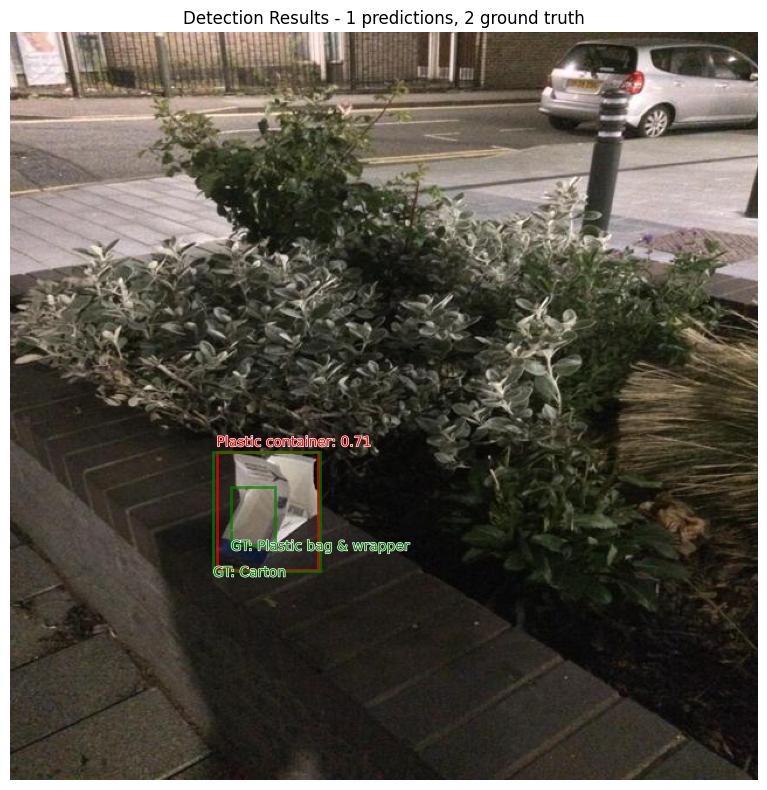

In [53]:
# Test inference on a single image
if 'dataset' in locals() and len(dataset.dataset) > 0:
    # Make filenames global first
    dataset.make_fname_global()

    # Get first image from dataset
    for sample_idx in range(0, 10, 10):
        sample = dataset.dataset[dataset.dataset["split"] == "test"].iloc[sample_idx]
        image_path = sample['image']

        # Load and display original image
        image = Image.open(image_path).convert('RGB')
        print(f" Testing inference on: {image_path}")
        print(f"   Image size: {image.size}")

        # Run inference
        predictions = detection_model.inference(image)

        print(f" Found {len(predictions['boxes'])} detections")
        # Get ground truth for comparison
        annotation_path = sample["annotation"]
        ground_truth = dataset.read_annotation(annotation_path)

        print(f" Ground truth: {len(ground_truth[0])} objects")

        # Visualize results
        visualize_detections(
            np.array(image),
            predictions,
            ground_truth,
            title=f"Detection Results - {len(predictions['boxes'])} predictions, {len(ground_truth[0])} ground truth"
        )
else:
    print(" Dataset not loaded. Please check the data paths above.")

In [54]:
# Run evaluation on a subset of the dataset
# For demonstration, we'll use a small subset
if 'dataset' in locals():

    # Make sure the output directory exists
    predictions_outdir = "local/outputs/detection_preds"
    os.makedirs(predictions_outdir, exist_ok=True)

    try:
        # Run evaluation with ontology translation
        results = detection_model.eval(
            dataset=dataset,
            split="test",
            predictions_outdir=predictions_outdir,
            results_per_sample=True
        )

        print(" Evaluation completed!")

    except Exception as e:
        print(f" Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
else:
    print("  Dataset not loaded. Please check the data paths above.")


  0%|          | 0/75 [00:00<?, ?it/s]

 Evaluation completed!



Metrics DataFrame:


,mean,Aluminium foil,Battery,Blister pack,Bottle,Bottle cap,Broken glass,Can,Carton,Cup,...,Plastic utensils,Pop tab,Rope & strings,Scrap metal,Shoe,Squeezable tube,Straw,Styrofoam piece,Unlabeled litter,Cigarette
AP,0.492678,0.0,NaN,NaN,0.522727,0.363636,0.0,0.795455,0.636364,0.545455,...,1.0,0.181818,0.0,NaN,NaN,NaN,0.649351,0.545455,0.181818,0.181818
Precision,0.759444,0.0,NaN,NaN,0.833333,1.000000,0.0,0.958333,1.000000,0.625000,...,1.0,1.000000,0.0,NaN,NaN,NaN,0.555556,1.000000,0.750000,1.000000
Recall,0.499760,0.0,NaN,NaN,0.576923,0.300000,0.0,0.884615,0.666667,0.500000,...,1.0,0.111111,0.0,NaN,NaN,NaN,0.833333,0.500000,0.142857,0.185185
TP,5.750000,0.0,NaN,NaN,15.000000,3.000000,0.0,23.000000,8.000000,5.000000,...,1.0,1.000000,0.0,NaN,NaN,NaN,5.000000,3.000000,3.000000,5.000000
FP,1.350000,0.0,NaN,NaN,3.000000,0.000000,0.0,1.000000,0.000000,3.000000,...,0.0,0.000000,0.0,NaN,NaN,NaN,4.000000,0.000000,1.000000,0.000000
FN,6.050000,3.0,NaN,NaN,11.000000,7.000000,2.0,3.000000,4.000000,5.000000,...,0.0,8.000000,1.0,NaN,NaN,NaN,1.000000,3.000000,18.000000,22.000000
mAP@[0.5:0.95],0.409727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AUC-PR,0.942472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


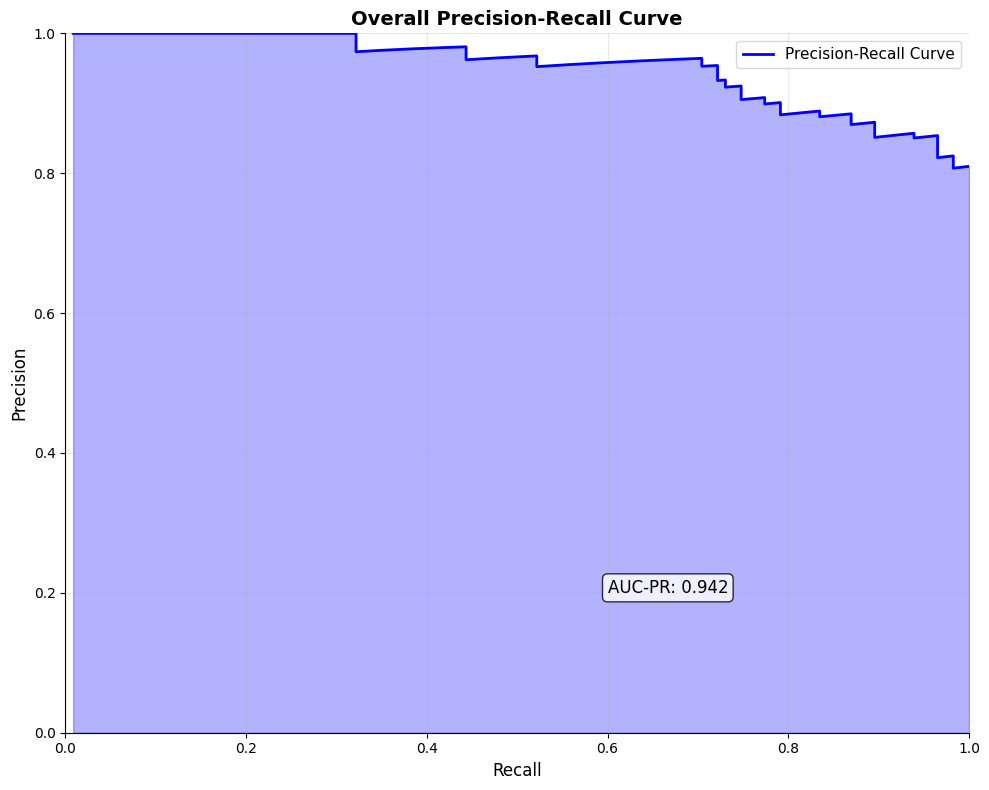

Precision-Recall Curve plotted with AUC-PR: 0.942


In [55]:
# Check the structure of results
if isinstance(results, dict):
    metrics_df = results["metrics_df"]
    metrics_factory = results["metrics_factory"]
else:
    # Fallback for old format
    metrics_df = results
    metrics_factory = None

# Display the metrics DataFrame
print("\nMetrics DataFrame:")

cols = list(metrics_df.columns)
last_col = cols[-1]
new_order = [last_col] + cols[:-1]
metrics_df = metrics_df[new_order]

display(metrics_df)

# Visualize Precision-Recall Curve if metrics factory is available
if metrics_factory is not None:
    # Get the precision-recall curve data
    curve_data = metrics_factory.get_overall_precision_recall_curve()
    auc_pr = metrics_factory.compute_auc_pr()

    # Create the plot
    plt.figure(figsize=(10, 8))

    # Plot the precision-recall curve
    plt.plot(
        curve_data["recall"],
        curve_data["precision"],
        linewidth=2,
        color="blue",
        label="Precision-Recall Curve",
    )

    # Fill the area under the curve
    plt.fill_between(
        curve_data["recall"], curve_data["precision"], alpha=0.3, color="blue"
    )

    # Add AUC-PR annotation
    plt.text(
        0.6,
        0.2,
        f"AUC-PR: {auc_pr:.3f}",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
    )

    # Customize the plot
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.title("Overall Precision-Recall Curve", fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)

    # Set axis limits
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    # Add some styling
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

    print(f"Precision-Recall Curve plotted with AUC-PR: {auc_pr:.3f}")

else:
    print("Precision-recall curve data not available.")
    print("The evaluation results don't contain the metrics factory object.")

    # Alternative: Show the metrics DataFrame
    if hasattr(metrics_df, "index") and "AP" in metrics_df.index:
        print("\nAvailable metrics:")
        for metric in metrics_df.index:
            if metric in ["AP", "mAP@[0.5:0.95]", "AUC-PR"]:
                mean_value = metrics_df.loc[metric, "mean"]
                print(f"{metric}: {mean_value:.3f}")